Epoch 0, Loss: 2481.163574
Epoch 200, Loss: 12.463707
Epoch 400, Loss: 7.144855
Epoch 600, Loss: 5.205992
Epoch 800, Loss: 3.859333
Epoch 1000, Loss: 2.692726
Epoch 1200, Loss: 1.722704
Epoch 1400, Loss: 1.013769
Epoch 1600, Loss: 0.557920
Epoch 1800, Loss: 2.166485
Epoch 2000, Loss: 0.545994
Epoch 2200, Loss: 1.885316
Epoch 2400, Loss: 0.617570
Epoch 2600, Loss: 1178.783081
Epoch 2800, Loss: 0.528131
Epoch 3000, Loss: 0.223117
Epoch 3200, Loss: 0.363782
Epoch 3400, Loss: 0.792771
Epoch 3600, Loss: 551.310547
Epoch 3800, Loss: 7.491344
Epoch 4000, Loss: 2.100278
Epoch 4200, Loss: 0.097300
Epoch 4400, Loss: 0.257251
Epoch 4600, Loss: 0.086702
Epoch 4800, Loss: 0.059979
Epoch 5000, Loss: 4.847792
Epoch 5200, Loss: 0.051645
Epoch 5400, Loss: 16.413071
Epoch 5600, Loss: 0.042624
Epoch 5800, Loss: 0.073212


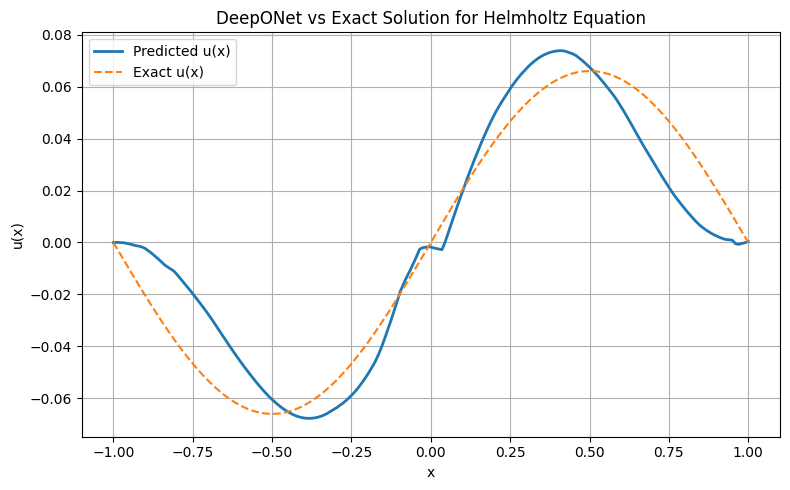

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -----------------------------
# 1. Chebyshev Nodes and Diff Matrix
# -----------------------------
def chebyshev_nodes(N):
    k = torch.arange(N + 1, dtype=torch.float32)
    x = torch.cos(torch.pi * k / N)
    return x.unsqueeze(1)

def chebyshev_diff_matrix(N):
    x = torch.cos(torch.pi * torch.arange(N + 1) / N)
    c = torch.ones(N + 1)
    c[0], c[-1] = 2, 2
    c = c * ((-1) ** torch.arange(N + 1))
    X = x.repeat(N + 1, 1)
    dX = X - X.T
    D = torch.outer(c, 1 / c) / (dX + torch.eye(N + 1))
    D = D - torch.diag(torch.sum(D, dim=1))
    for i in range(N + 1):
        if i == 0:
            D[i, i] = (2 * N ** 2 + 1) / 6
        elif i == N:
            D[i, i] = -(2 * N ** 2 + 1) / 6
        else:
            D[i, i] = -x[i] / (2 * (1 - x[i] ** 2))
    return x.unsqueeze(1), D

# -----------------------------
# 2. Forcing Function
# -----------------------------
def forcing_function(x):
    return torch.sin(torch.pi * x)

# -----------------------------
# 3. Exact Solution for Helmholtz Equation
# -----------------------------
def exact_solution(x, k):
    pi_tensor = torch.tensor(torch.pi)  # make pi a tensor
    k_tensor = torch.tensor(k, dtype=torch.float32)  # ensure k is a tensor

    denom = k_tensor**2 - pi_tensor**2
    rhs = torch.sin(pi_tensor) / denom

    # Compute sin and cos for k
    sin_k = torch.sin(k_tensor)
    cos_k = torch.cos(k_tensor)
    sin_neg_k = torch.sin(-k_tensor)
    cos_neg_k = torch.cos(-k_tensor)

    # Build system matrix and RHS
    M = torch.stack([
        torch.tensor([sin_neg_k.item(), cos_neg_k.item()]),
        torch.tensor([sin_k.item(), cos_k.item()])
    ])
    b = torch.tensor([-rhs.item(), -rhs.item()])

    # Solve for A and B
    AB = torch.linalg.solve(M, b)
    A, B = AB[0], AB[1]

    # Compute solution
    u_p = torch.sin(pi_tensor * x) / denom
    u_h = A * torch.sin(k_tensor * x) + B * torch.cos(k_tensor * x)
    return u_p + u_h

# -----------------------------
# 4. DeepONet Model
# -----------------------------
class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim=64):
        super(DeepONet, self).__init__()
        self.branch_net = nn.Sequential(
            nn.Linear(branch_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, f_input, x_input):
        branch_out = self.branch_net(f_input)
        trunk_out = self.trunk_net(x_input)
        combined = branch_out * trunk_out
        return self.output_layer(combined)

# -----------------------------
# 5. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N = 20
k_val = 5.0
lr = 1e-3
epochs = 6000

x_nodes, D = chebyshev_diff_matrix(N)
x_nodes = x_nodes.to(device)
D = D.to(device)
f_vals = forcing_function(x_nodes).to(device)

model = DeepONet(branch_input_dim=1, trunk_input_dim=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()

# -----------------------------
# 6. Training Loop
# -----------------------------
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    u_pred = model(f_vals, x_nodes)
    du = D @ u_pred
    d2u = D @ du
    residual = d2u + k_val**2 * u_pred - f_vals
    loss_pde = mse(residual, torch.zeros_like(residual))
    loss_bc = mse(u_pred[0], torch.tensor([0.0], device=device)) + mse(u_pred[-1], torch.tensor([0.0], device=device))
    loss = loss_pde + loss_bc
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# -----------------------------
# 7. Evaluation and Plot
# -----------------------------
model.eval()
with torch.no_grad():
    x_plot = torch.linspace(-1, 1, 200).unsqueeze(1).to(device)
    f_plot = forcing_function(x_plot)
    u_pred_plot = model(f_plot, x_plot).cpu()
    u_exact_plot = exact_solution(x_plot.cpu(), k_val)

plt.figure(figsize=(8, 5))
plt.plot(x_plot.cpu().numpy(), u_pred_plot.numpy(), label='Predicted u(x)', linewidth=2)
plt.plot(x_plot.cpu().numpy(), u_exact_plot.numpy(), label='Exact u(x)', linestyle='--')
plt.title('DeepONet vs Exact Solution for Helmholtz Equation')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:

import torch
import math

# def get_clenshaw_curtis_weights_mat(n: int) -> torch.Tensor:
#     """
#     Returns a diagonal matrix of Clenshaw-Curtis weights for n intervals (n+1 nodes).
#     Nodes are assumed in descending order.
#     """
#     N = n + 1
#     weights = torch.zeros(N, dtype=torch.float64)
#     for k in range(N):
#         s = 0.0
#         for j in range(1, n // 2 + 1):
#             s += (2 / (4 * j**2 - 1)) * math.cos(2 * j * k * math.pi / n)
#         weights[k] = (2 / n) * (1 - s)
#     # Reverse for descending Chebyshev nodes
#     weights = torch.flip(weights, dims=[0])
#     return torch.diag(weights)

def get_clenshaw_curtis_weights_mat(n: int) -> torch.Tensor:
    """
    Returns a diagonal matrix of Clenshaw-Curtis weights for n intervals (n+1 nodes).
    Nodes are in descending order.
    """
    # Number of nodes
    N = n + 1
    # k = torch.arange(0, N, dtype=torch.float64)

    # Compute weights using the explicit formula with correction factor
    weights = torch.zeros(N, dtype=torch.float64)
    m = N // 2  # floor(N/2)
    for i in range(N):
        s = 0.0
        for j in range(1, m + 1):
            bj = 0.5 if j == m and N % 2 == 0 else 1.0  # correction factor for last term
            s += bj * (2 * math.cos(2 * j * i * math.pi / N)) / (4 * j**2 - 1)
        weights[i] = (2 / N) * (1 - s)

    # Reverse for descending Chebyshev nodes
    weights = torch.flip(weights, dims=[0])

    # Return diagonal matrix
    return torch.diag(weights)

# Test function: f(x) = cos(x)
def test_clenshaw_curtis(n):
    # Nodes in descending order
    nodes = torch.flip(torch.cos(torch.arange(0, n+1, dtype=torch.float64) * math.pi / n), dims=[0])
    f_values = torch.cos(nodes)
    
    # Get weights matrix
    W = get_clenshaw_curtis_weights_mat(n)
    
    # Approximate integral
    approx_integral = torch.matmul(W.diag(), f_values).sum().item()
    
    # Exact integral of cos(x) over [-1,1]
    exact_integral = math.sin(1) - math.sin(-1)  # = 2*sin(1)
    
    print(f"n = {n}")
    print(f"Approx integral: {approx_integral:.12f}")
    print(f"Exact integral:  {exact_integral:.12f}")
    print(f"Error:           {abs(approx_integral - exact_integral):.2e}")
    print("-" * 50)

# Run tests for a few n values
for n in [4, 8, 16, 32, 64, 128]:
    test_clenshaw_curtis(n)


n = 4
Approx integral: 1.567226253448
Exact integral:  1.682941969616
Error:           1.16e-01
--------------------------------------------------
n = 8
Approx integral: 1.626137465148
Exact integral:  1.682941969616
Error:           5.68e-02
--------------------------------------------------
n = 16
Approx integral: 1.655619691343
Exact integral:  1.682941969616
Error:           2.73e-02
--------------------------------------------------
n = 32
Approx integral: 1.669692585342
Exact integral:  1.682941969616
Error:           1.32e-02
--------------------------------------------------
n = 64
Approx integral: 1.676441146849
Exact integral:  1.682941969616
Error:           6.50e-03
--------------------------------------------------
n = 128
Approx integral: 1.679725371185
Exact integral:  1.682941969616
Error:           3.22e-03
--------------------------------------------------


In [12]:
dtype = torch.float32
def cheb_sensors(m):
    j = torch.arange(m, dtype=dtype, device=device)
    xi = torch.cos(j*math.pi/(m-1))
    return xi.to(torch.float32)


cheb_sensors(5)

tensor([ 1.0000e+00,  7.0711e-01, -4.3711e-08, -7.0711e-01, -1.0000e+00])

Epoch 0, Loss: 912.469543
Epoch 200, Loss: 0.205227
Epoch 400, Loss: 0.066355
Epoch 600, Loss: 0.030749
Epoch 800, Loss: 0.022106
Epoch 1000, Loss: 0.019647
Epoch 1200, Loss: 0.018261
Epoch 1400, Loss: 0.016996
Epoch 1600, Loss: 0.015695
Epoch 1800, Loss: 0.014346
Epoch 2000, Loss: 0.012991
Epoch 2200, Loss: 5.616419
Epoch 2400, Loss: 0.010061
Epoch 2600, Loss: 0.008472
Epoch 2800, Loss: 0.008734
Epoch 3000, Loss: 0.006313
Epoch 3200, Loss: 0.005444
Epoch 3400, Loss: 0.004684
Epoch 3600, Loss: 0.007065
Epoch 3800, Loss: 0.004054
Epoch 4000, Loss: 0.002718
Epoch 4200, Loss: 0.004492
Epoch 4400, Loss: 0.001891
Epoch 4600, Loss: 0.006715
Epoch 4800, Loss: 0.002193
Epoch 5000, Loss: 0.001036
Epoch 5200, Loss: 0.001024
Epoch 5400, Loss: 0.000816
Epoch 5600, Loss: 0.000649
Epoch 5800, Loss: 0.006134


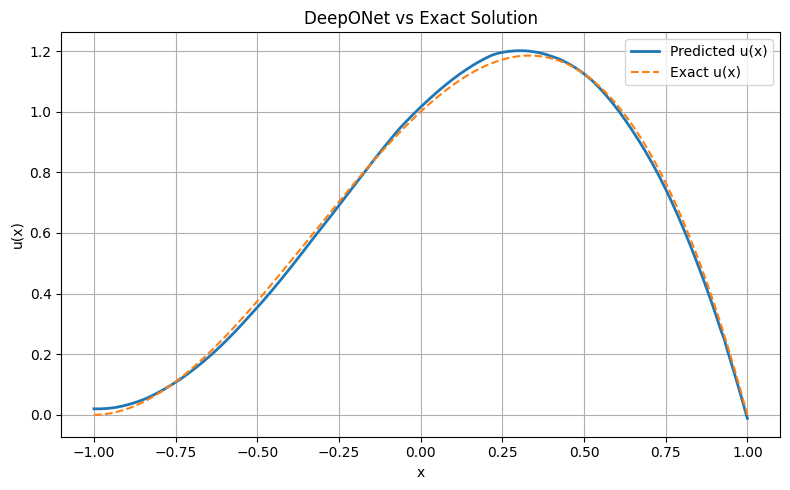

In [26]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# -----------------------------
# 1. Chebyshev Nodes and Diff Matrix
# -----------------------------
def chebyshev_nodes(N):
    k = torch.arange(N + 1, dtype=torch.float32)
    x = torch.cos(torch.pi * k / N)
    return x.unsqueeze(1)

def chebyshev_diff_matrix(N):
    x = torch.cos(torch.pi * torch.arange(N + 1) / N)
    c = torch.ones(N + 1)
    c[0], c[-1] = 2, 2
    c = c * ((-1) ** torch.arange(N + 1))
    X = x.repeat(N + 1, 1)
    # dX = X - X.T
    dX = X.T - X
    D = torch.outer(c, 1 / c) / (dX + torch.eye(N + 1))
    D = D - torch.diag(torch.sum(D, dim=1))
    for i in range(N + 1):
        if i == 0:
            D[i, i] = (2 * N ** 2 + 1) / 6
        elif i == N:
            D[i, i] = -(2 * N ** 2 + 1) / 6
        else:
            D[i, i] = -x[i] / (2 * (1 - x[i] ** 2))
    return x.unsqueeze(1), D

# -----------------------------
# 2. Forcing Function
# -----------------------------
def forcing_function(x):
    return -25*x**3 - 25*x**2 + 19*x + 23

# -----------------------------
# 3. Exact Solution
# -----------------------------
def exact_solution(x, k):
    return -x**3 - x**2 + x + 1

# -----------------------------
# 4. DeepONet Model
# -----------------------------
class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim=64):
        super(DeepONet, self).__init__()
        self.branch_net = nn.Sequential(
            nn.Linear(branch_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, f_input, x_input):
        branch_out = self.branch_net(f_input)
        trunk_out = self.trunk_net(x_input)
        combined = branch_out * trunk_out
        return self.output_layer(combined)

# -----------------------------
# 5. Training Setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N = 20
k_val = 5.0
lr = 1e-3
epochs = 6000

x_nodes, D = chebyshev_diff_matrix(N)
x_nodes = x_nodes.to(device)
D = D.to(device)
f_vals = forcing_function(x_nodes).to(device)

model = DeepONet(branch_input_dim=1, trunk_input_dim=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()

# -----------------------------
# 6. Training Loop
# -----------------------------
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    u_pred = model(f_vals, x_nodes)
    du = D @ u_pred
    d2u = D @ du
    residual = d2u + k_val**2 * u_pred - f_vals
    loss_pde = mse(residual, torch.zeros_like(residual))
    loss_bc = mse(u_pred[0], torch.tensor([0.0], device=device)) + mse(u_pred[-1], torch.tensor([0.0], device=device))
    loss = loss_pde + loss_bc
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# -----------------------------
# 7. Evaluation and Plot
# -----------------------------
model.eval()
with torch.no_grad():
    x_plot = torch.linspace(-1, 1, 200).unsqueeze(1).to(device)
    f_plot = forcing_function(x_plot)
    u_pred_plot = model(f_plot, x_plot).cpu()
    u_exact_plot = exact_solution(x_plot.cpu(), k_val)

plt.figure(figsize=(8, 5))
plt.plot(x_plot.cpu().numpy(), u_pred_plot.numpy(), label='Predicted u(x)', linewidth=2)
plt.plot(x_plot.cpu().numpy(), u_exact_plot.numpy(), label='Exact u(x)', linestyle='--')
plt.title('DeepONet vs Exact Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
# def chebyshev_diff_matrix(N: int):
#     x = torch.cos(torch.pi * torch.arange(N + 1, device=device) / N)
#     c = torch.ones(N + 1, device=device)
#     c[0] = 2
#     c[-1] = 2
#     c = c * ((-1) ** torch.arange(N + 1, device=device))
#     X = x.repeat(N + 1, 1)
#     # dX = X - X.T
#     dX = X.T - X
#     D = (c.unsqueeze(1) / c.unsqueeze(0)) / (dX + torch.eye(N + 1, device=device))
#     D = D - torch.diag(torch.sum(D, dim=1))
#     return x, D

def chebyshev_diff_matrix(N):
    x = torch.cos(torch.pi * torch.arange(N + 1) / N)
    c = torch.ones(N + 1)
    c[0], c[-1] = 2, 2
    c = c * ((-1) ** torch.arange(N + 1))
    X = x.repeat(N + 1, 1)
    # dX = X - X.T
    dX = X.T - X
    D = torch.outer(c, 1 / c) / (dX + torch.eye(N + 1))
    D = D - torch.diag(torch.sum(D, dim=1))
    for i in range(N + 1):
        if i == 0:
            D[i, i] = (2 * N ** 2 + 1) / 6
        elif i == N:
            D[i, i] = -(2 * N ** 2 + 1) / 6
        else:
            D[i, i] = -x[i] / (2 * (1 - x[i] ** 2))
    return x.unsqueeze(1), D

    
def test_chebyshev_diff_matrix():
    N = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x, D = chebyshev_diff_matrix(N)
    
    # Test function: u(x) = x^3
    u = x**3
    # Analytical derivative: u'(x) = 3x^2
    u_prime_exact = 3 * x**2
    
    # Numerical derivative using D
    u_prime_num = D @ u
    
    # Compute error
    error = torch.norm(u_prime_num - u_prime_exact)
    
    print("Chebyshev nodes:", x)
    print("Numerical derivative:", u_prime_num)
    print("Exact derivative:", u_prime_exact)
    print(f"Error norm: {error.item():.6e}")


test_chebyshev_diff_matrix()

Chebyshev nodes: tensor([[ 1.0000e+00],
        [ 9.5106e-01],
        [ 8.0902e-01],
        [ 5.8779e-01],
        [ 3.0902e-01],
        [-4.3711e-08],
        [-3.0902e-01],
        [-5.8779e-01],
        [-8.0902e-01],
        [-9.5106e-01],
        [-1.0000e+00]])
Numerical derivative: tensor([[3.0000e+00],
        [2.7135e+00],
        [1.9635e+00],
        [1.0365e+00],
        [2.8647e-01],
        [5.9605e-08],
        [2.8647e-01],
        [1.0365e+00],
        [1.9635e+00],
        [2.7135e+00],
        [3.0000e+00]])
Exact derivative: tensor([[3.0000e+00],
        [2.7135e+00],
        [1.9635e+00],
        [1.0365e+00],
        [2.8647e-01],
        [5.7321e-15],
        [2.8647e-01],
        [1.0365e+00],
        [1.9635e+00],
        [2.7135e+00],
        [3.0000e+00]])
Error norm: 3.802038e-05


In [22]:

def test_chebyshev_diff_matrix():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    N = 10
    x, D = chebyshev_diff_matrix(N)
    
    # Test function: u(x) = x^3
    u = x**3  # shape (N+1,)
    
    # Analytical derivative: u'(x) = 3x^2
    u_prime_exact = 3 * x**2
    
    # Numerical derivative using D
    u_prime_num = D @ u
    
    # Compute error
    error = torch.norm(u_prime_num - u_prime_exact)
    
    print("Chebyshev nodes:", x)
    print("Numerical derivative:", u_prime_num)
    print("Exact derivative:", u_prime_exact)
    print(f"Error norm: {error.item():.6e}")

test_chebyshev_diff_matrix()

Chebyshev nodes: tensor([ 1.0000e+00,  9.5106e-01,  8.0902e-01,  5.8779e-01,  3.0902e-01,
        -4.3711e-08, -3.0902e-01, -5.8779e-01, -8.0902e-01, -9.5106e-01,
        -1.0000e+00])
Numerical derivative: tensor([3.0000e+00, 2.7135e+00, 1.9635e+00, 1.0365e+00, 2.8647e-01, 5.9605e-08,
        2.8647e-01, 1.0365e+00, 1.9635e+00, 2.7135e+00, 3.0000e+00])
Exact derivative: tensor([3.0000e+00, 2.7135e+00, 1.9635e+00, 1.0365e+00, 2.8647e-01, 5.7321e-15,
        2.8647e-01, 1.0365e+00, 1.9635e+00, 2.7135e+00, 3.0000e+00])
Error norm: 1.418039e-06
